
# 🚲 Seoul Bike Sharing Demand — End-to-End Project (Python → Tableau)

This notebook is a **complete, commented pipeline** you can run step-by-step:

1. **Setup & Data Loading**  
2. **Data Inspection, Cleaning & Feature Engineering**  
3. **Exploratory Data Analysis (EDA)**  
4. **Dataset Preparation & Export**  
5. **Dataset Preparation & Feature Encoding**  
6. **Baseline Model: Linear Regression**  
7. **XGBoost Model Training & Evaluation**  
8. **Sample Predictions**  
9. **SHAP Analysis for Model Interpretation**  
10. **Temporal & Trend Analysis**  
11. **Export Machine Learning Predictions & Feature-Engineered Dataset**


> Dataset citation: *Seoul Bike Sharing Demand [Dataset]. (2020). UCI Machine Learning Repository.* https://doi.org/10.24432/C5F62R


---
# 1. Setup & Data Loading
In this section, we:
- Import required libraries  
- Load the dataset  
- Preview the data (size, columns, first few rows)  


In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from xgboost import XGBRegressor, plot_importance
import shap

# Load dataset
df = pd.read_csv("SeoulBikeData.csv", encoding="ISO-8859-1")
print(df.shape)
df.head()


(8760, 14)


,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


---
# 2. Data Inspection, Cleaning & Feature Engineering
In this section, we:
- **Inspect Data Structure**
- Rename columns for readability  
- Handle `Date` column and extract features (`Year`, `Month`, `Day`, `Weekday`)  
- Create a new `Work Day` flag  
- Keep only functional days (`Functioning Day == Yes`)  



In [2]:
# Check column names, types, and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

In [3]:
# Rename columns
df.rename(columns={
    'Rented Bike Count': 'Bike_count',
    'Temperature(°C)': 'Temp_c',
    'Humidity(%)': 'Humidity',
    'Wind speed (m/s)': 'Wind_m_s',
    'Visibility (10m)': 'Visibility',
    'Dew point temperature(°C)': 'Dew_point_c',
    'Solar Radiation (MJ/m2)': 'Solar_rad',
    'Rainfall(mm)': 'Rain_mm',
    'Snowfall (cm)': 'Snow_cm'
}, inplace=True)

# Date handling
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.day_name()

# Work Day flag
df['Work Day'] = (df['Weekday'].isin(['Monday','Tuesday','Wednesday','Thursday','Friday'])) & (df['Holiday'] == "No Holiday")

# Keep only functional days
df = df[df['Functioning Day'] == 'Yes']


---
# 3. Exploratory Data Analysis (EDA)
- Avg Monthly Rentals vs Temp
- Avg Hourly Rentals by Season (Workday vs Non-Workday)
- Avg Hourly Rentals by Season (Overall)
- Avg Monthly Rentals (Workday vs Non-Workday)
- Avg Hourly Rentals (Workday vs Non-Workday)
- Avg Rentals by Weather Categories


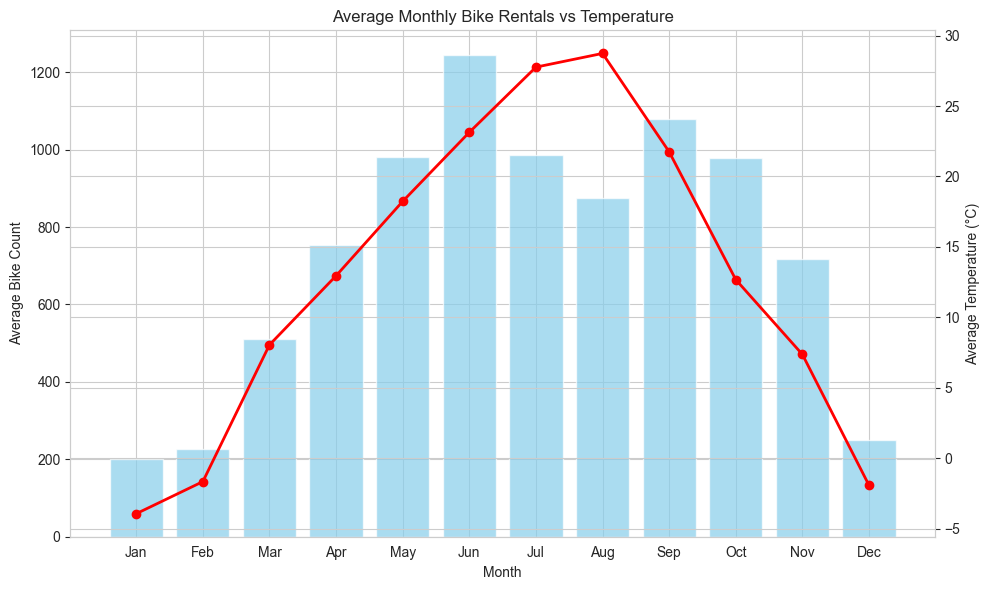

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Grouping data ---
bar_data = df.groupby('Month')['Bike_count'].mean().reset_index()
line_data = df.groupby('Month')['Temp_c'].mean().reset_index()

# --- Merge data ---
plot_data = pd.merge(bar_data, line_data, on="Month")

# --- Plot setup ---
sns.set_style("whitegrid")
fig, ax1 = plt.subplots(figsize=(10, 6))

# Barplot = average rentals
ax1.bar(
    plot_data['Month'],
    plot_data['Bike_count'],
    color="skyblue", alpha=0.7
)

ax1.set_ylabel("Average Bike Count")
ax1.set_xlabel("Month")

# Secondary y-axis for temperature line
ax2 = ax1.twinx()
ax2.plot(plot_data['Month'], plot_data['Temp_c'],
         color='red', marker='o', linewidth=2, label='Temperature')
ax2.set_ylabel("Average Temperature (°C)")

# Month labels
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun',
                     'Jul','Aug','Sep','Oct','Nov','Dec'])

# Title
ax1.set_title("Average Monthly Bike Rentals vs Temperature")

fig.tight_layout()
plt.show()


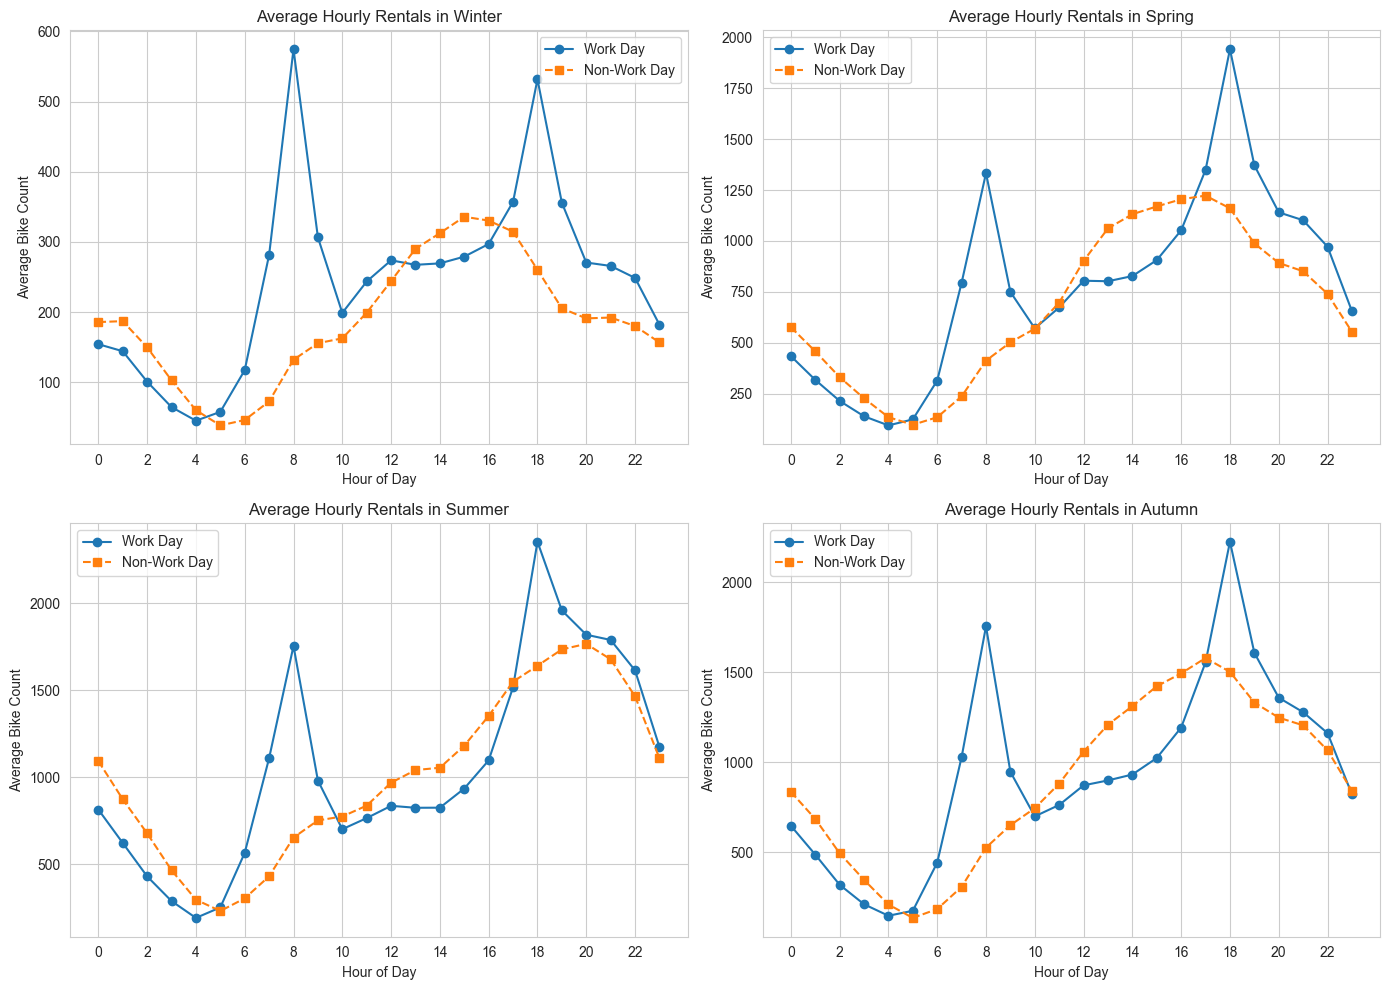

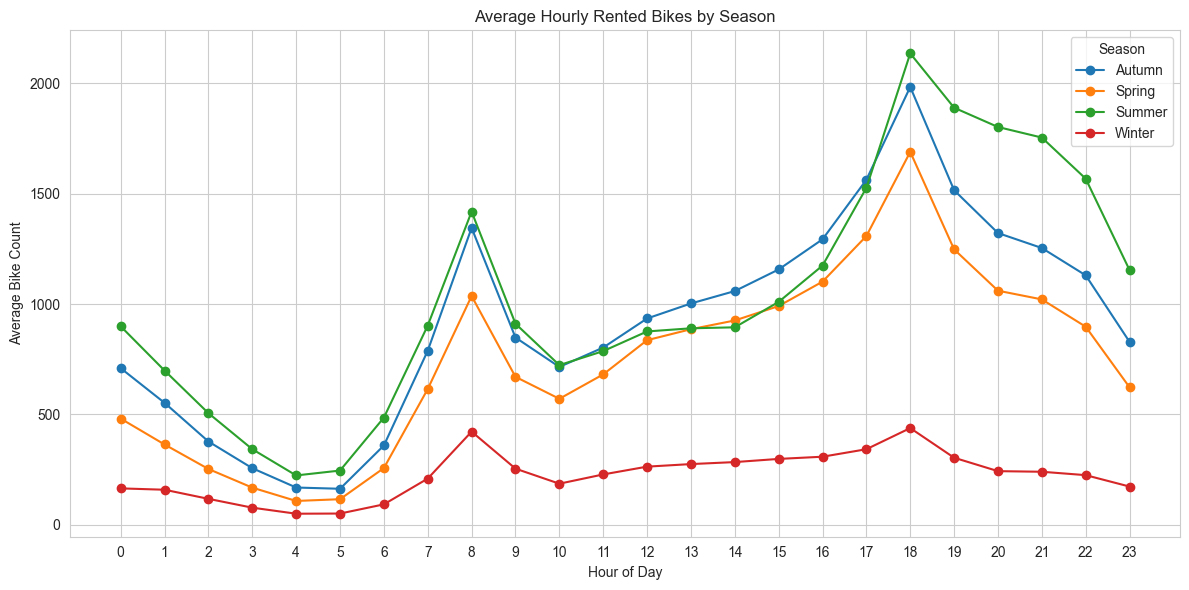

In [5]:
# --- Average Hourly Rentals by Season & Work Day ---
hourly_season_workday = (
    df.groupby(['Seasons','Hour','Work Day'])['Bike_count']
      .mean()
      .reset_index()
)

seasons = df['Seasons'].unique()
plt.figure(figsize=(14,10))

for i, season in enumerate(seasons, 1):
    plt.subplot(2, 2, i)
    subset = hourly_season_workday[hourly_season_workday['Seasons'] == season]
    
    for work_status, style in zip([True, False], ['-o', '--s']):
        temp = subset[subset['Work Day'] == work_status]
        label = "Work Day" if work_status else "Non-Work Day"
        plt.plot(temp['Hour'], temp['Bike_count'], style, label=label)
    
    plt.title(f"Average Hourly Rentals in {season}")
    plt.xlabel("Hour of Day")
    plt.ylabel("Average Bike Count")
    plt.xticks(range(0,24,2))
    plt.legend()

plt.tight_layout()
plt.show()

# --- Average Hourly Rentals by Season (Overall) ---
hourly_season = (
    df.groupby(['Hour','Seasons'])['Bike_count']
      .mean()
      .reset_index()
)

pivot_hour_season = hourly_season.pivot(index='Hour', columns='Seasons', values='Bike_count')

plt.figure(figsize=(12,6))
pivot_hour_season.plot(kind='line', marker='o', ax=plt.gca())
plt.title("Average Hourly Rented Bikes by Season")
plt.xlabel("Hour of Day")
plt.ylabel("Average Bike Count")
plt.legend(title="Season")
plt.xticks(range(0,24))
plt.grid(True)
plt.tight_layout()
plt.show()


1. **Morning peak**  
   Bike demand rises in the morning (05:00–10:00), with the highest point at 08:00. This peak is more pronounced in spring, summer, and autumn compared to winter.  

2. **Evening peak**  
   A second peak occurs in the evening (16:00–20:00), with the highest point at 18:00. As with the morning, this surge is stronger outside winter.  


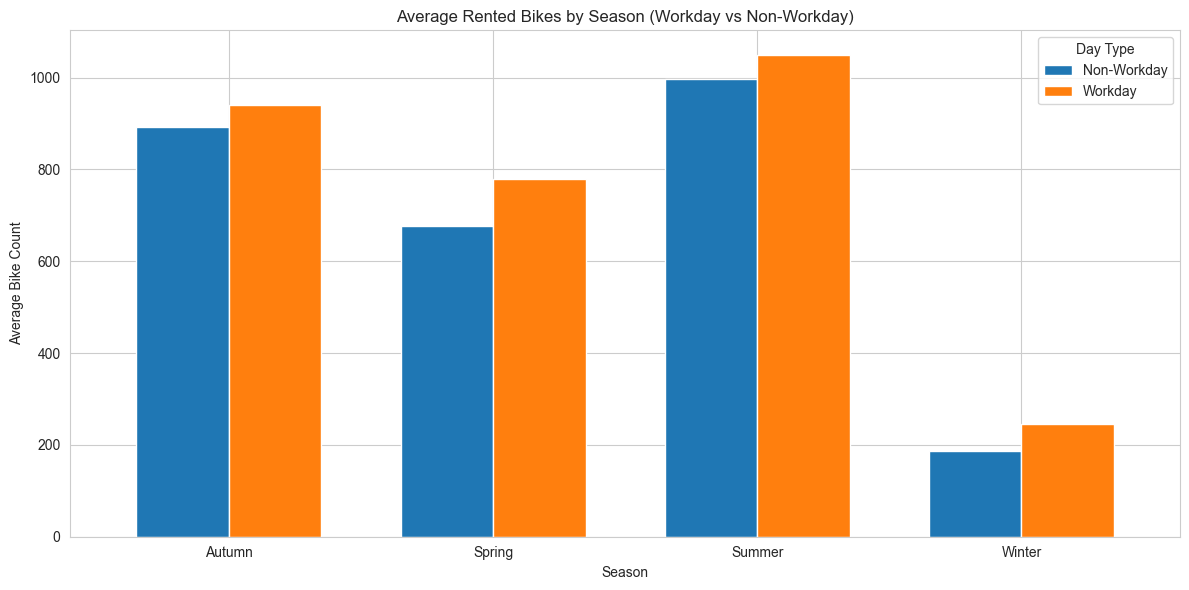

In [6]:
# Group by Season and Work Day
seasonal_avg = (
    df.groupby(['Seasons','Work Day'])['Bike_count']
      .mean()
      .reset_index()
)

# Pivot for grouped bar plotting
pivot_data = seasonal_avg.pivot(index='Seasons', columns='Work Day', values='Bike_count')

# Plot grouped bar chart
pivot_data.plot(kind='bar', figsize=(12,6), width=0.7, color=["#1f77b4","#ff7f0e"])
plt.title("Average Rented Bikes by Season (Workday vs Non-Workday)")
plt.xlabel("Season")
plt.ylabel("Average Bike Count")
plt.legend(title="Day Type", labels=["Non-Workday","Workday"])
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


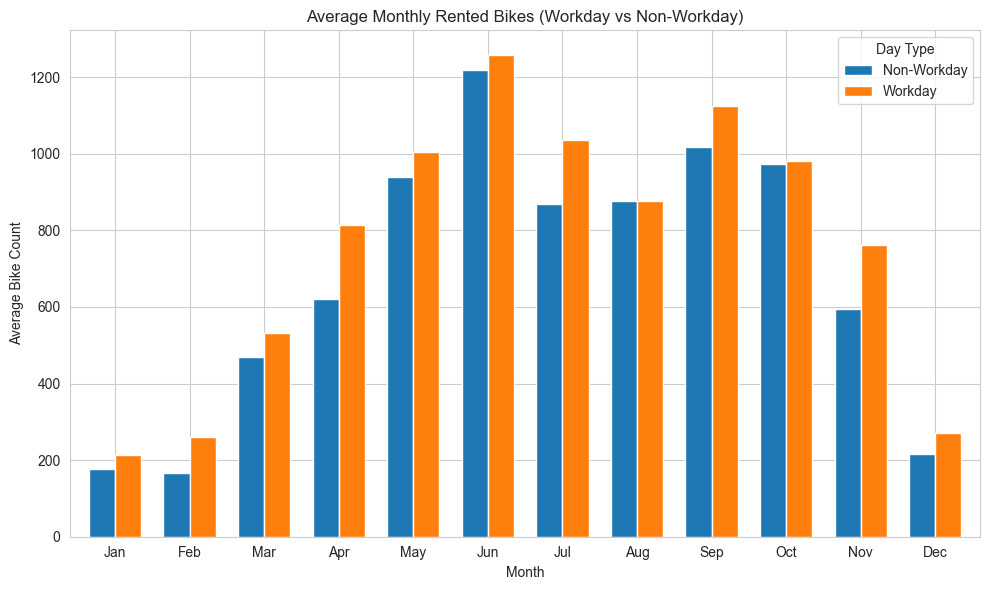

In [7]:
# Add Month Name
df['Month_name'] = df['Month'].apply(lambda x: 
    ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'][x-1])

# Group by Month Name and Work Day
monthly_avg = (
    df.groupby(['Month_name','Work Day'])['Bike_count']
      .mean()
      .reset_index()
)

# Pivot for grouped bar plotting
pivot_month = monthly_avg.pivot(index='Month_name', columns='Work Day', values='Bike_count')

# Ensure calendar order
month_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
pivot_month = pivot_month.reindex(month_order)

# Plot grouped bar chart
pivot_month.plot(kind='bar', figsize=(10,6), width=0.7, color=["#1f77b4","#ff7f0e"])
plt.title("Average Monthly Rented Bikes (Workday vs Non-Workday)")
plt.xlabel("Month")
plt.ylabel("Average Bike Count")
plt.legend(title="Day Type", labels=["Non-Workday","Workday"])
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In August and October, bike rentals on Workdays and Non-Workdays are nearly identical, showing balanced demand across both day types. In contrast, months like April , July and November show clear gaps, with Workdays recording higher rentals than Non-Workdays

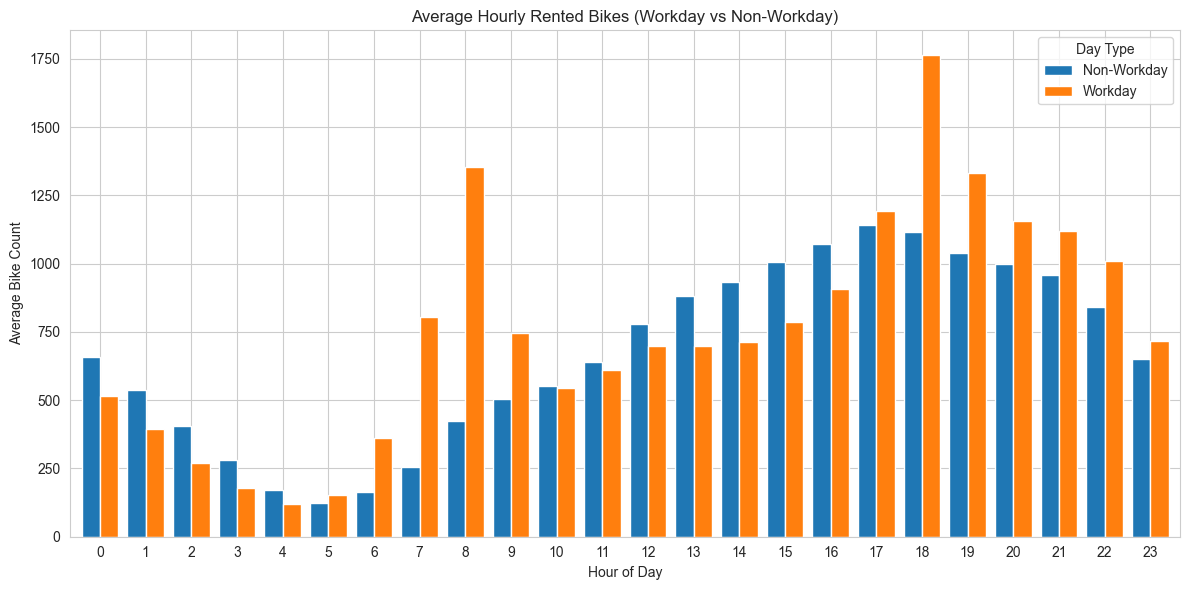

In [8]:
# Group by Hour and Work Day
hourly_avg = (
    df.groupby(['Hour','Work Day'])['Bike_count']
      .mean()
      .reset_index()
)

# Pivot for grouped bar plotting
pivot_hour = hourly_avg.pivot(index='Hour', columns='Work Day', values='Bike_count')

# Ensure hours are in order
pivot_hour = pivot_hour.reindex(range(0,24))

# Plot grouped bar chart
pivot_hour.plot(kind='bar', figsize=(12,6), width=0.8, color=["#1f77b4","#ff7f0e"])
plt.title("Average Hourly Rented Bikes (Workday vs Non-Workday)")
plt.xlabel("Hour of Day")
plt.ylabel("Average Bike Count")
plt.legend(title="Day Type", labels=["Non-Workday","Workday"])
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


### **Average Hourly Rented Bikes: Workday vs Non-Workday**

**Workdays**  
- **Sharp commuter peaks** at **06:00–09:00** and **17:00–19:00**.  
- **Midday dip** creates a **double peak** pattern.  
- **Lower rentals overnight** (**00:00–05:00**).  

**Non-Workdays**  
- **Moderate rentals overnight** (**00:00–05:00**).  
- **Gradual increase** with a **midday/afternoon peak (~17:00)**.  
- **Smoother, leisure-driven** demand pattern.  

**Overall:**  
- **Workdays = commute-driven usage with sharp spikes**  
- **Non-Workdays = leisure-oriented usage, smoother trend**  
- **Trend suggestion:** overlay **linear or LOWESS regression** to highlight **general daily pattern**


# Average Bike Rentals by Weather Categories ↓ #
  - Illustrates rentals by humidity, wind, rainfall, and snowfall levels.

In [9]:
# 1️⃣ Humidity bins
humidity_bins = [0, 40, 60, 80, 100]
humidity_labels = ["Low", "Moderate", "High", "Very High"]
df['Humidity_cat'] = pd.cut(df['Humidity'], bins=humidity_bins, labels=humidity_labels)
hum_avg = df.groupby('Humidity_cat')['Bike_count'].mean().reset_index()

# 2️⃣ Wind bins
wind_bins = [0, 2, 4, 6, df['Wind_m_s'].max()]
wind_labels = ["Calm", "Light", "Moderate", "Strong"]
df['Wind_cat'] = pd.cut(df['Wind_m_s'], bins=wind_bins, labels=wind_labels, include_lowest=True)
wind_avg = df.groupby('Wind_cat')['Bike_count'].mean().reset_index()

# 3️⃣ Rainfall bins (dynamic if max is small)
max_rain = df['Rain_mm'].max()
if max_rain > 15:
    rain_bins = [0, 1, 5, 15, max_rain]
else:
    rain_bins = [0, 0.1, 1, 5, max_rain+0.1]
rain_labels = ["No Rain", "Light", "Moderate", "Heavy"]
df['Rain_cat'] = pd.cut(df['Rain_mm'], bins=rain_bins, labels=rain_labels, include_lowest=True)
rain_avg = df.groupby('Rain_cat')['Bike_count'].mean().reset_index()

# 4️⃣ Snowfall bins (dynamic if max is small)
max_snow = df['Snow_cm'].max()
if max_snow > 15:
    snow_bins = [0, 1, 5, 15, max_snow]
else:
    snow_bins = [0, 0.1, 1, 5, max_snow+0.1]
snow_labels = ["No Snow", "Light", "Moderate", "Heavy"]
df['Snow_cat'] = pd.cut(df['Snow_cm'], bins=snow_bins, labels=snow_labels, include_lowest=True)
snow_avg = df.groupby('Snow_cat')['Bike_count'].mean().reset_index()


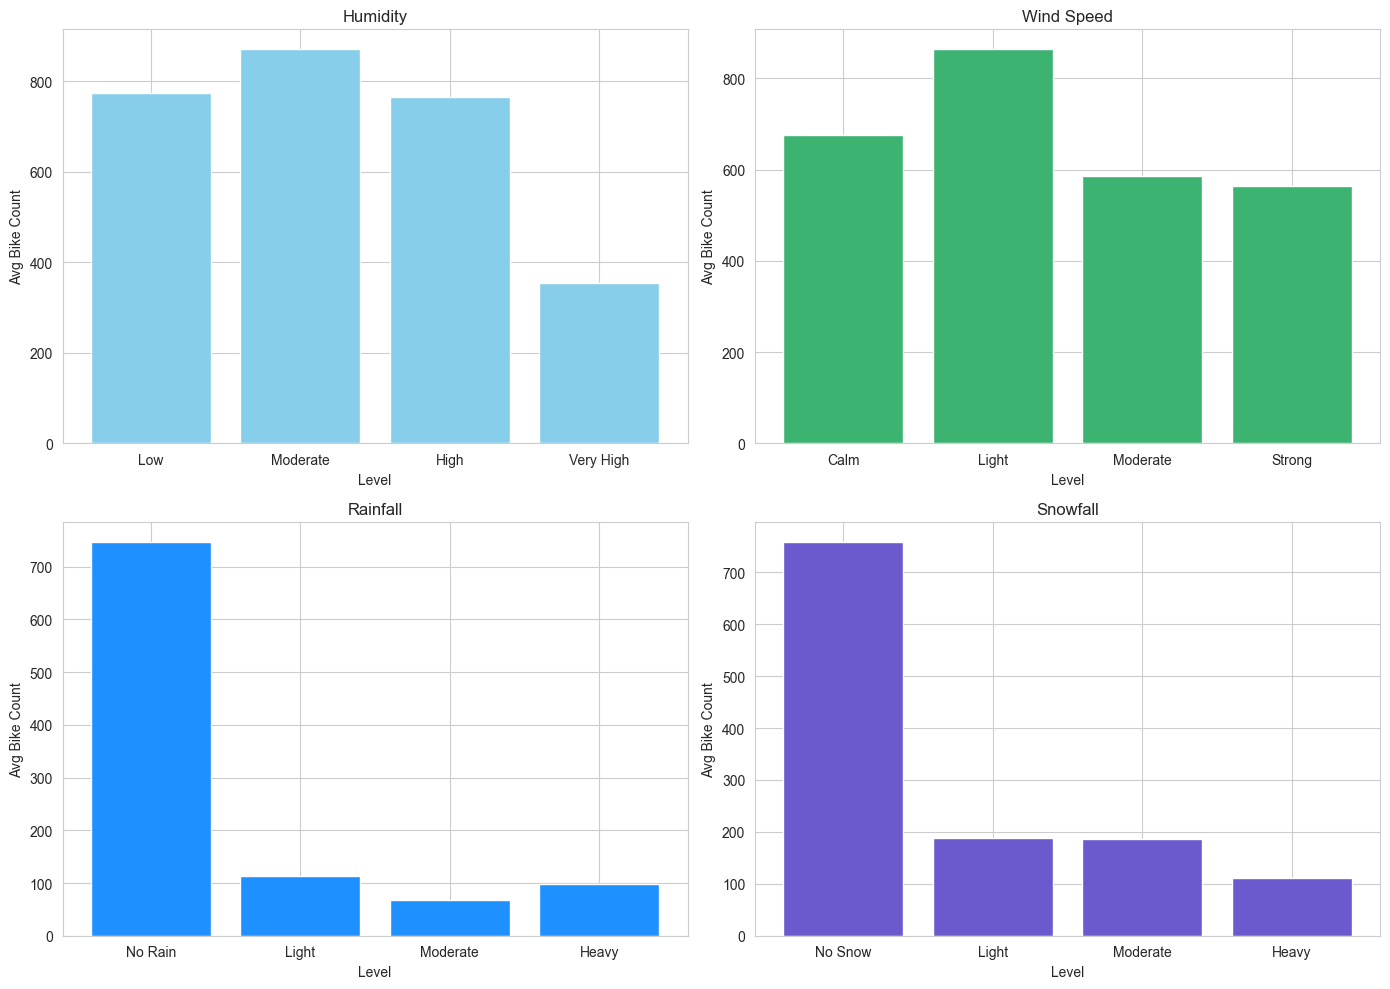

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(14,10))

# Humidity
axes[0,0].bar(hum_avg['Humidity_cat'], hum_avg['Bike_count'], color='skyblue')
axes[0,0].set_title("Humidity")
axes[0,0].set_xlabel("Level")
axes[0,0].set_ylabel("Avg Bike Count")

# Wind
axes[0,1].bar(wind_avg['Wind_cat'], wind_avg['Bike_count'], color='mediumseagreen')
axes[0,1].set_title("Wind Speed")
axes[0,1].set_xlabel("Level")
axes[0,1].set_ylabel("Avg Bike Count")

# Rainfall
axes[1,0].bar(rain_avg['Rain_cat'], rain_avg['Bike_count'], color='dodgerblue')
axes[1,0].set_title("Rainfall")
axes[1,0].set_xlabel("Level")
axes[1,0].set_ylabel("Avg Bike Count")

# Snowfall
axes[1,1].bar(snow_avg['Snow_cat'], snow_avg['Bike_count'], color='slateblue')
axes[1,1].set_title("Snowfall")
axes[1,1].set_xlabel("Level")
axes[1,1].set_ylabel("Avg Bike Count")

plt.tight_layout()
plt.show()


---
# 4.  Dataset Preparation & Export
 In this section, we:
 - Select relevant columns for modeling/export
 - Save the feature-engineered dataset

In [17]:
# --- Relevant columns for CSV ---
feature_cols = [
    'Date','Year','Month_name','Day','Hour','Weekday','Work Day','Seasons','Holiday','Functioning Day',
    'Temp_c','Humidity','Humidity_cat','Wind_m_s','Wind_cat',
    'Rain_mm','Rain_cat','Snow_cm','Snow_cat','Bike_count'
]

feature_df = df[feature_cols]

# --- Save CSV ---
feature_df.to_csv("SeoulBike_FeatureEngineered.csv", index=False)
print("Feature-engineered CSV saved: SeoulBike_FeatureEngineered.csv")


Feature-engineered CSV saved: SeoulBike_FeatureEngineered.csv


---
## Predicting Bike Rentals Using Machine Learning
## 5. Dataset Preparation & Feature Encoding

In this section, we:

- Select features and target variable
- Encode categorical columns
- Split into train/test sets

In [18]:
#  Feature Engineering

X = df[['Temp_c','Humidity','Wind_m_s','Visibility','Dew_point_c',
        'Solar_rad','Rain_mm','Hour',
        'Seasons','Holiday','Work Day']]
y = df['Bike_count']



In [19]:

# Encode categorical columns
categorical_col = X.select_dtypes(include=['category', 'object', 'bool']).columns.tolist()

encoder = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop = None, handle_unknown='ignore'), categorical_col)
    ],
    remainder='passthrough'  # Keep numerical columns as is
)

# Fit and transform X
X_enc = encoder.fit_transform(X)

# Get feature names
numerical_col = [col for col in X.columns if col not in categorical_col]
categorical_enc = encoder.named_transformers_['cat'].get_feature_names_out(categorical_col)
all_col_enc = list(categorical_enc) + numerical_col

# Convert to DataFrame with float type
X_enc_df = pd.DataFrame(X_enc, columns=all_col_enc, index=X.index).astype(float)

In [20]:
# Train/Test split using the fully numeric DataFrame
X_train, X_test, y_train, y_test = train_test_split(
    X_enc_df, y, test_size=0.25, random_state=43
)


---
## 6. Baseline Model: Linear Regression

In this section, we:

- Train a baseline Linear Regression model
- Evaluate model performance using cross-validation
- Calculate metrics on the test set (R², RMSE, MAE)


In [21]:
# Linear Regression
lr = LinearRegression()
kfold = KFold(n_splits=5, shuffle=True, random_state=121)

# Cross-validation
cv_scores = cross_val_score(lr, X_enc, y, scoring='r2', cv=kfold)

# Fit and predict
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

# Evaluation
print("Baseline Linear Regression")
print(f"CV R² (mean ± std): {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
print(f"Test R²: {r2_score(y_test, lr_pred):.3f}")
print(f"Test RMSE: {mean_squared_error(y_test, lr_pred, squared=False):.2f}")
print(f"Test MAE: {mean_absolute_error(y_test, lr_pred):.2f}")


Baseline Linear Regression
CV R² (mean ± std): 0.543 ± 0.014
Test R²: 0.553
Test RMSE: 445.96
Test MAE: 332.00


---
## 7. XGBoost Model Training & Evaluation  

In this section, we:  

- Configure and train the XGBoost model on training data  
- Make predictions on the test set  
- Evaluate model performance (MSE, RMSE, R²)  
- Visualize actual vs predicted bike demand   


In [22]:
# Train Model

xgb_model = XGBRegressor(
    n_estimators=2000,
    learning_rate=0.015,
    max_depth=7,
    min_child_weight=2,
    gamma=1,
    subsample=0.7,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1,
    eval_metric='mae',
    random_state=121
)

xgb_model.fit(X_train, y_train)

# Predictions & Evaluation

y_pred = xgb_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("📊 Model Performance Metrics:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.3f}")


📊 Model Performance Metrics:
MSE: 25403.73
RMSE: 159.39
MAE: 91.84
R² Score: 0.943


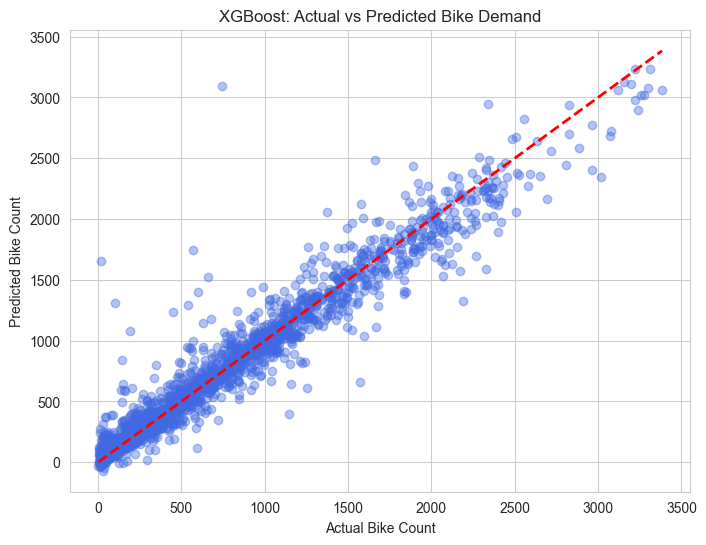

In [23]:
# Scatter plot
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.4, color="royalblue")
plt.plot([y_test.min(), y_test.max()], 
         [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Bike Count")
plt.ylabel("Predicted Bike Count")
plt.title("XGBoost: Actual vs Predicted Bike Demand")
plt.show()

---
## 8. Sample Predictions

In this section, we:

- Compare predicted vs actual bike counts for sample rows
- Inspect the effect of features on specific predictions

In [24]:
# Sample Predictions

sample_input = X_test.iloc[:5].copy()
sample_input['Predicted_Bike_Count'] = y_pred[:5]
sample_input['Actual_Bike_Count'] = y_test.iloc[:5].values
print("\n📝 Sample Predictions vs Actual:")
print(sample_input)



📝 Sample Predictions vs Actual:
      Seasons_Autumn  Seasons_Spring  Seasons_Summer  Seasons_Winter   
2663             0.0             1.0             0.0             0.0  \
4999             0.0             0.0             1.0             0.0   
2331             0.0             1.0             0.0             0.0   
263              0.0             0.0             0.0             1.0   
8757             1.0             0.0             0.0             0.0   

      Holiday_Holiday  Holiday_No Holiday  Work Day_False  Work Day_True   
2663              0.0                 1.0             0.0            1.0  \
4999              0.0                 1.0             0.0            1.0   
2331              0.0                 1.0             0.0            1.0   
263               0.0                 1.0             0.0            1.0   
8757              0.0                 1.0             0.0            1.0   

      Temp_c  Humidity  Wind_m_s  Visibility  Dew_point_c  Solar_rad  Rain_mm

---
## 9. SHAP Analysis for Model Interpretation

In this section, we:

- Use SHAP to explain model predictions
- Visualize feature contributions to predictions
- Interpret insights for actionable decisions


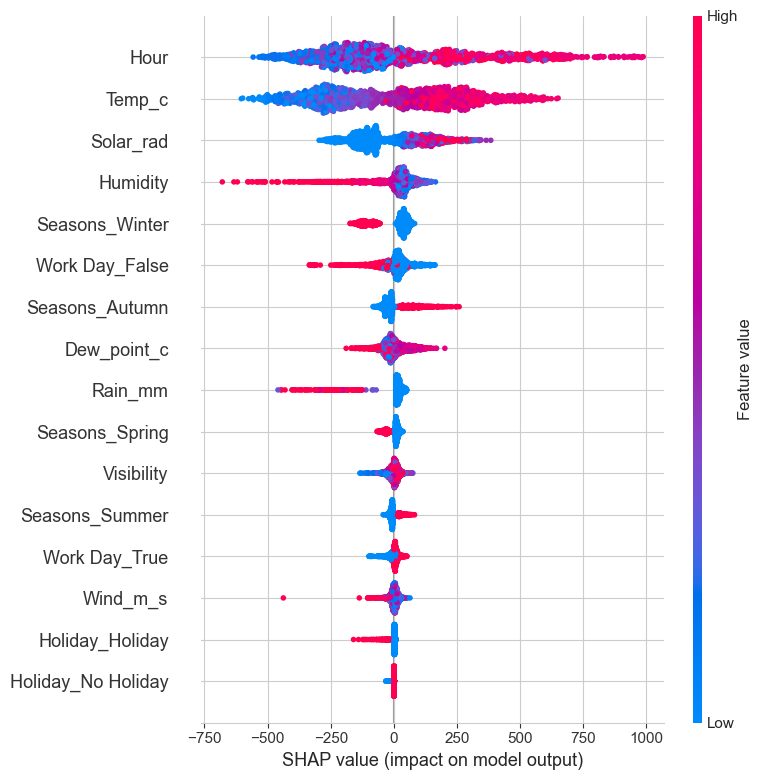

In [25]:
# -------------------------------
# 3 Sample Predictions
# -------------------------------
import shap
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)


# SHAP Summary Plot Interpretation

This SHAP summary plot explains how each feature contributes to the XGBoost model's predictions of bike rentals.

---

## 1️⃣ Axes

- **X-axis (SHAP value):** Impact of a feature on predicted bike count.  
  - Positive → feature increases bike rentals  
  - Negative → feature decreases bike rentals  
  - Further from 0 → stronger effect

- **Y-axis (features):** Each row is a feature, sorted by importance (top = most important).

---

## 2️⃣ Color

- Color represents the **feature value** for each data point:  
  - **Blue** → low value of the feature  
  - **Red** → high value of the feature

**Examples:**
- **Temperature (`Temp_c`)**: Red points mostly on the positive side → high temperature increases bike rentals.  
- **Humidity (`Humidity`)**: Blue points (low humidity) push predictions up; red points (high humidity) push predictions down → high humidity reduces bike rentals.

---

## 3️⃣ Spread of Points

- Each point = one row in the dataset  
- Spread along x-axis shows variability of feature impact  
- Wide spread → feature has high influence on predictions

---

## 4️⃣ Key Insights

**Most important features:**
1. `Temp_c` and `Hour` → biggest drivers of bike demand  
2. `Solar_rad` and `Humidity` → moderately important  
3. Categorical features (Seasons, Workday/Holiday) → smaller but measurable impact

**Interpretation examples:**
- High `Temp_c` (red) → increases bike rentals  
- High `Humidity` (red) → decreases bike rentals  
- `Hour` → positive SHAP at certain hours (likely morning/evening peaks)

---

💡 **Summary:**  
The plot shows which features drive predictions and in which direction, helping to understand bike rental demand patterns. This insight can guide operational planning and dashboard visualizations.


---
---
# 10. Temporal & Trend Analysis
In this section, we:

- Analyze hourly bike rentals by weekday  
- Examine daily rentals across months  
- Visualize trends for insights on peaks and patterns


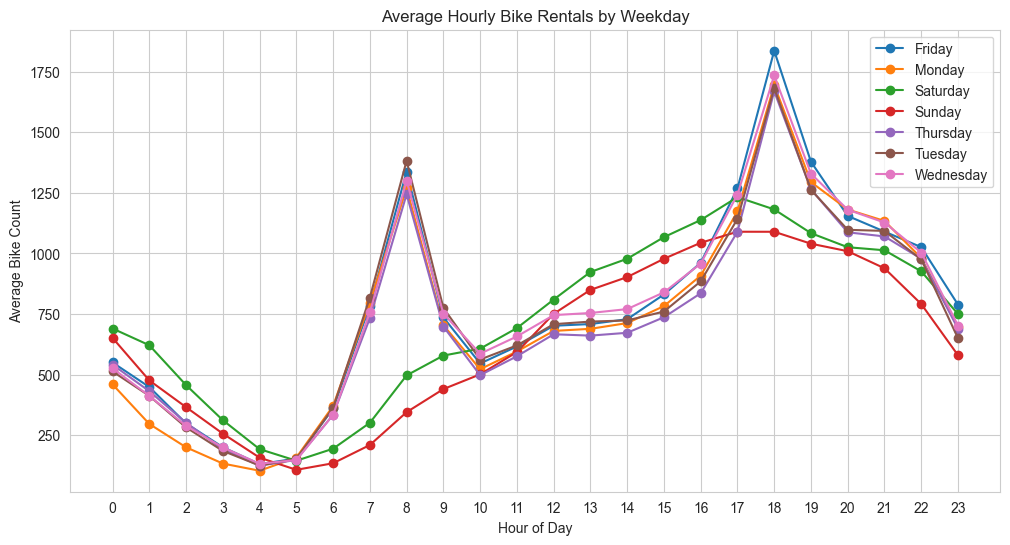

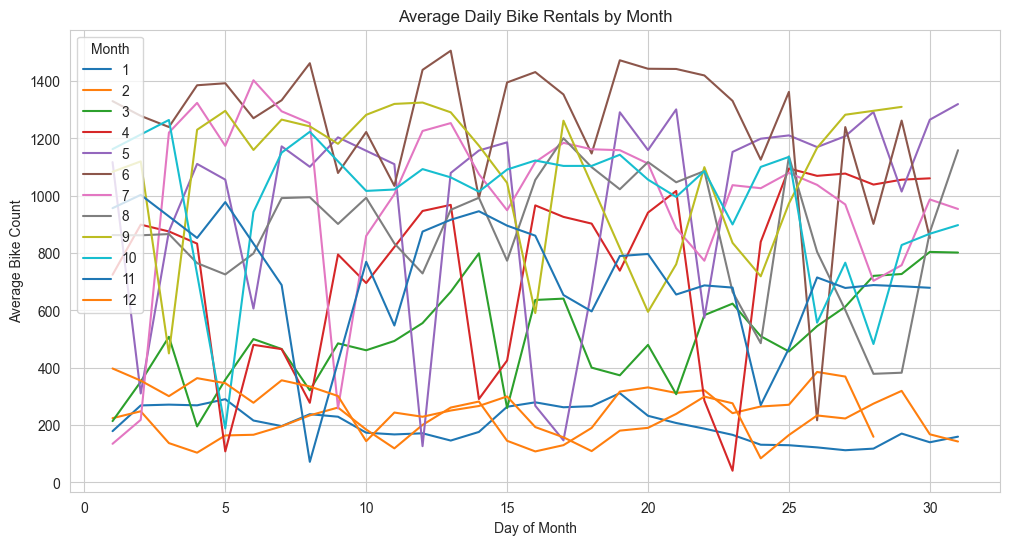

In [26]:
# Average hourly rentals by weekday
hourly_weekday = df.groupby(['Weekday','Hour'])['Bike_count'].mean().reset_index()

plt.figure(figsize=(12,6))
for day in hourly_weekday['Weekday'].unique():
    subset = hourly_weekday[hourly_weekday['Weekday'] == day]
    plt.plot(subset['Hour'], subset['Bike_count'], marker='o', label=day)

plt.title("Average Hourly Bike Rentals by Weekday")
plt.xlabel("Hour of Day")
plt.ylabel("Average Bike Count")
plt.xticks(range(0,24))
plt.legend()
plt.grid(True)
plt.show()

# Average daily rentals by month
daily_month = df.groupby(['Month','Day'])['Bike_count'].mean().reset_index()
plt.figure(figsize=(12,6))
sns.lineplot(data=daily_month, x='Day', y='Bike_count', hue='Month', palette="tab10")
plt.title("Average Daily Bike Rentals by Month")
plt.xlabel("Day of Month")
plt.ylabel("Average Bike Count")
plt.legend(title="Month")
plt.show()


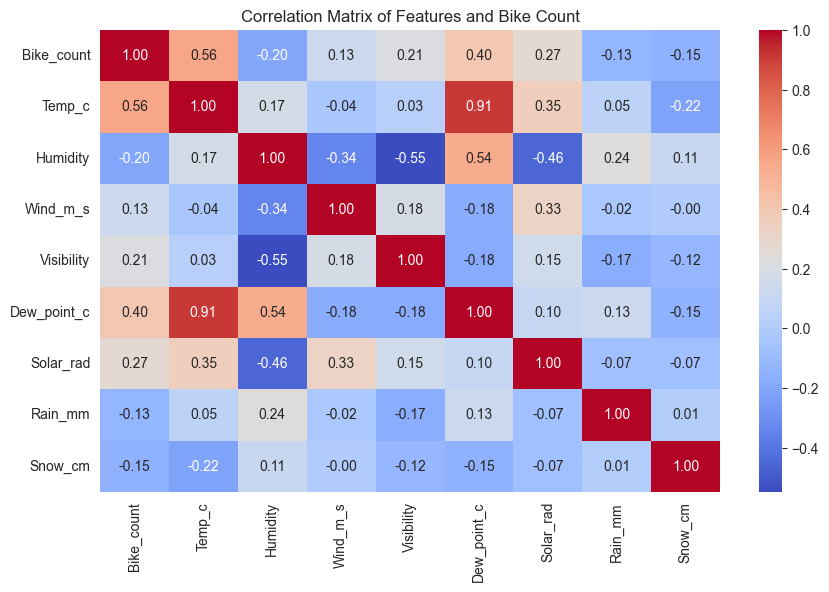

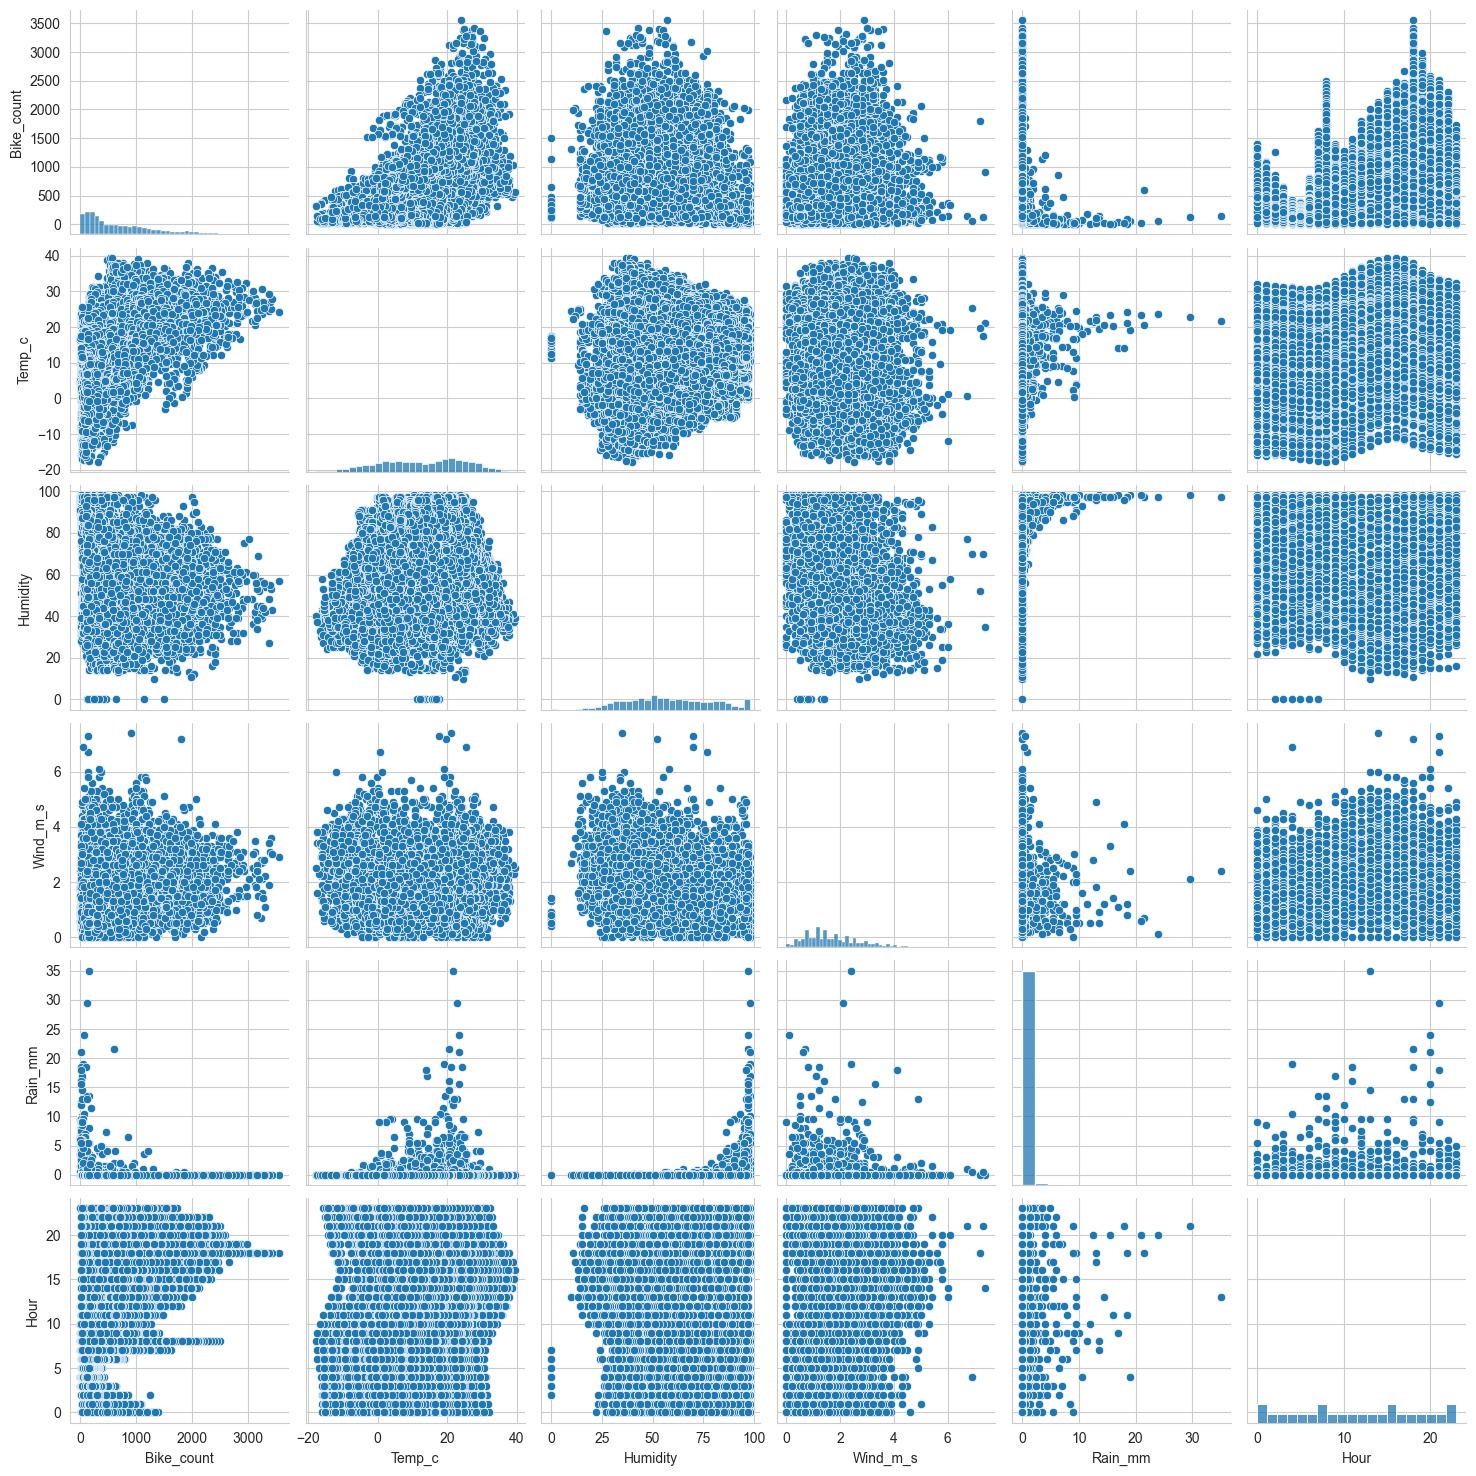

In [27]:
# Correlation matrix
corr_matrix = df[['Bike_count','Temp_c','Humidity','Wind_m_s','Visibility',
                  'Dew_point_c','Solar_rad','Rain_mm','Snow_cm']].corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Features and Bike Count")
plt.show()

# Pairplot for selected features
selected_features = ['Bike_count','Temp_c','Humidity','Wind_m_s','Rain_mm','Hour']
sns.pairplot(df[selected_features])
plt.show()


In [28]:
# Add predictions to the full dataset
df_pred = X_enc_df.copy()
df_pred['Actual_Bike_Count'] = y
df_pred['Predicted_Bike_Count'] = xgb_model.predict(X_enc_df)

# Save to CSV
df_pred.to_csv("SeoulBike_Predictions.csv", index=False)
print("Final predictions saved to 'SeoulBike_Predictions.csv'")

# Optionally save feature-engineered dataset (without encoding)
feature_cols = [
    'Date','Year','Month','Day','Hour','Weekday','Work Day','Seasons','Holiday','Functioning Day',
    'Temp_c','Humidity','Wind_m_s','Visibility','Dew_point_c','Solar_rad','Rain_mm','Snow_cm','Bike_count'
]
feature_df = df[feature_cols]
feature_df.to_csv("SeoulBike_FeatureEngineered.csv", index=False)
print("Feature-engineered dataset saved to 'SeoulBike_FeatureEngineered.csv'")


Final predictions saved to 'SeoulBike_Predictions.csv'
Feature-engineered dataset saved to 'SeoulBike_FeatureEngineered.csv'
